In [1]:
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import warnings
from eli5 import explain_weights, show_weights
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.model_selection import KFold, RepeatedKFold, RepeatedStratifiedKFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from xgboost import XGBClassifier, plot_importance, to_graphviz
from yellowbrick import ROCAUC
from yellowbrick.classifier import ClassificationReport

warnings.filterwarnings('ignore')

In [2]:
CV_N_REPEATS = 5
BINS = 10

In [3]:
df = pd.read_csv('Tourists_lakes_Nature.csv')
df.head()

,Area,Mean depth,Shorline lenght,Coast development index,Lake elongation index,Shorline overgrowth degree,Vegeation coverage of lake,Forests around the coasline,Tourism
0,43.3,3.7,2896,1.19,2.009346,60,3,13.987108,1
1,48.7,6.1,3293,1.33,1.916667,51,12,53.262759,1
2,167.8,6.9,7228,1.55,2.342995,60,20,52.702899,1
3,89.6,6.0,10085,2.83,7.777778,35,7,75.000000,0
4,81.2,4.5,4391,1.38,2.093750,49,8,68.805422,1


In [4]:
print('Shape of the dataset:', df.shape)

Shape of the dataset: (145, 9)


### ELEMENTARY DATA ANALYSIS (EDA)

Text(0, 0.5, 'Tourism')

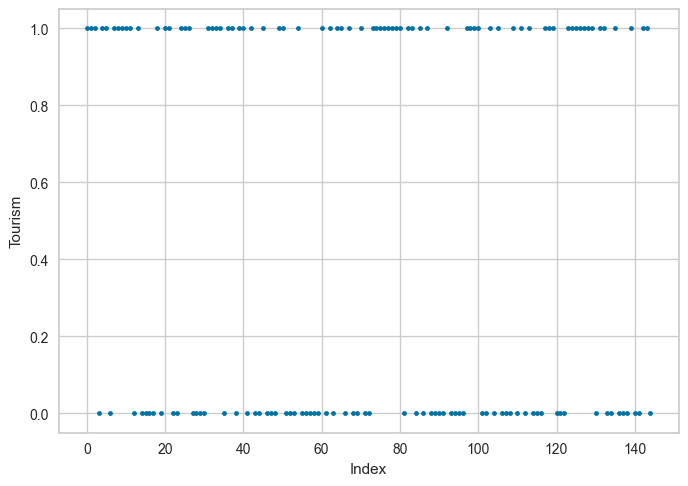

In [5]:
plt.figure()
plt.plot(df.Tourism, '.')
plt.xlabel('Index')
plt.ylabel('Tourism')

Text(0.5, 1.0, 'Seaborn countplot of Tourism within the dataset')

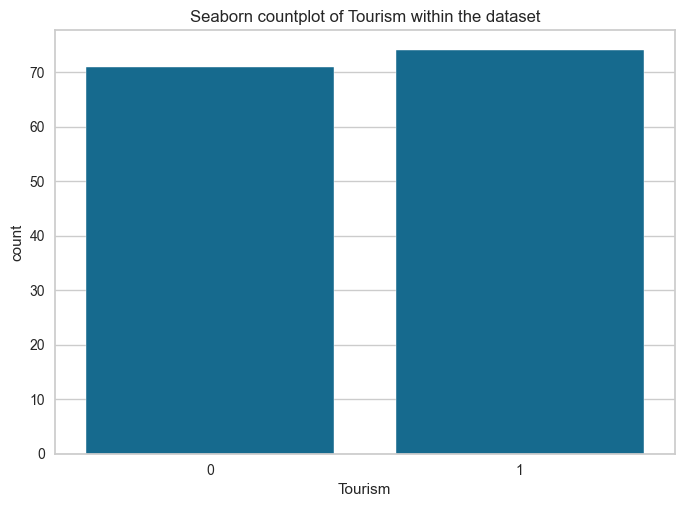

In [6]:
plt.figure()
ax = sns.countplot(data=df, x='Tourism')
ax.set_title('Seaborn countplot of Tourism within the dataset')

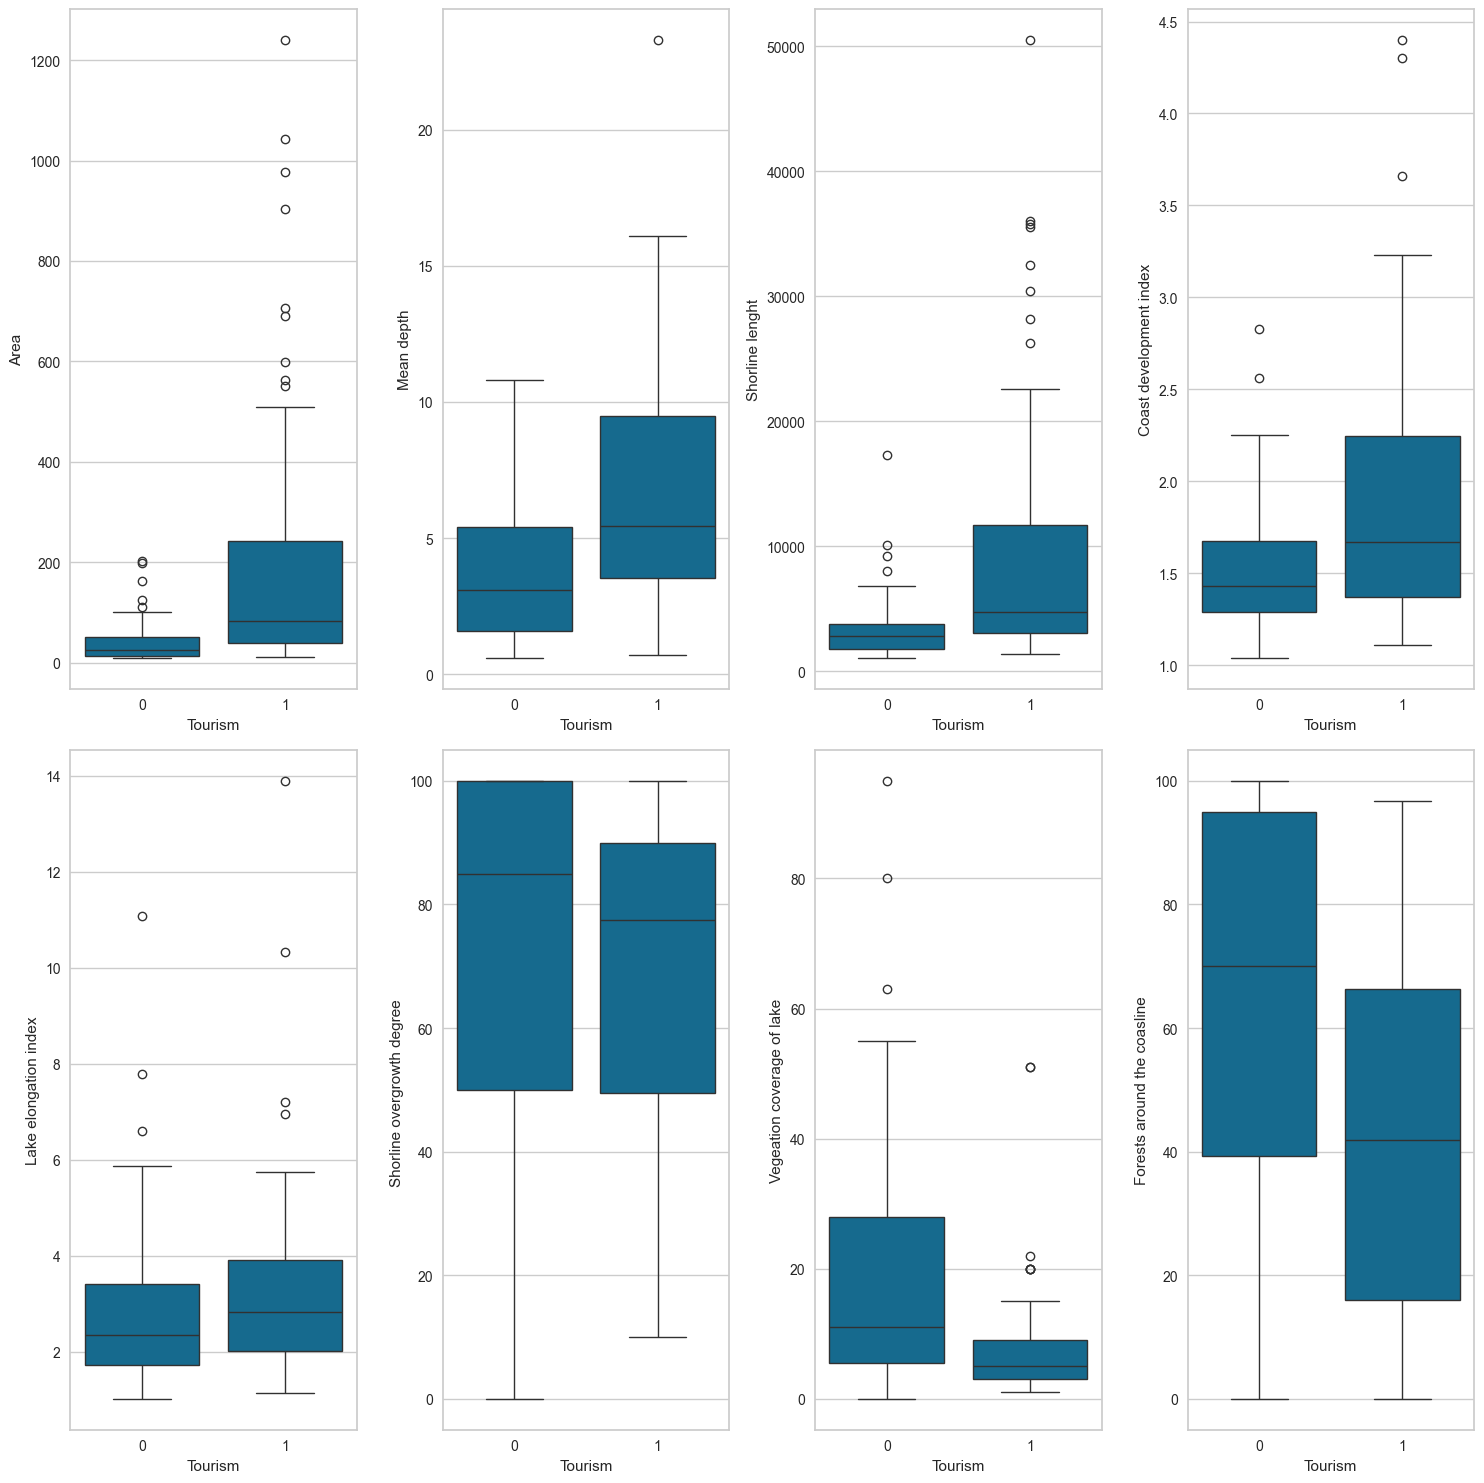

In [7]:
f, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 15))
sns.set(style='white', palette='Set3', color_codes=True)
sns.boxplot(y='Area', x='Tourism', data=df, orient='v', ax=axes[0, 0])
sns.boxplot(y='Mean depth', x='Tourism', data=df, orient='v', ax=axes[0, 1])
sns.boxplot(y='Shorline lenght', x='Tourism', data=df, orient='v', ax=axes[0, 2])
sns.boxplot(y='Coast development index', x='Tourism', data=df, orient='v', ax=axes[0, 3])
sns.boxplot(y='Lake elongation index', x='Tourism', data=df, orient='v', ax=axes[1, 0])
sns.boxplot(y='Shorline overgrowth degree ', x='Tourism', data=df, orient='v', ax=axes[1, 1])
sns.boxplot(y='Vegeation coverage of lake', x='Tourism', data=df, orient='v', ax=axes[1, 2])
sns.boxplot(y='Forests around the coasline', x='Tourism', data=df, orient='v', ax=axes[1, 3])
f.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9, hspace=0.4, wspace=0.3)
plt.tight_layout()

In [8]:
df_copy = df.copy(deep=True)
print('Number of zero entires in each attribute:\n')
print(df_copy.isnull().sum())

Number of zero entires in each attribute:

Area                           0
Mean depth                     0
Shorline lenght                0
Coast development index        0
Lake elongation index          0
Shorline overgrowth degree     0
Vegeation coverage of lake     0
Forests around the coasline    0
Tourism                        0
dtype: int64


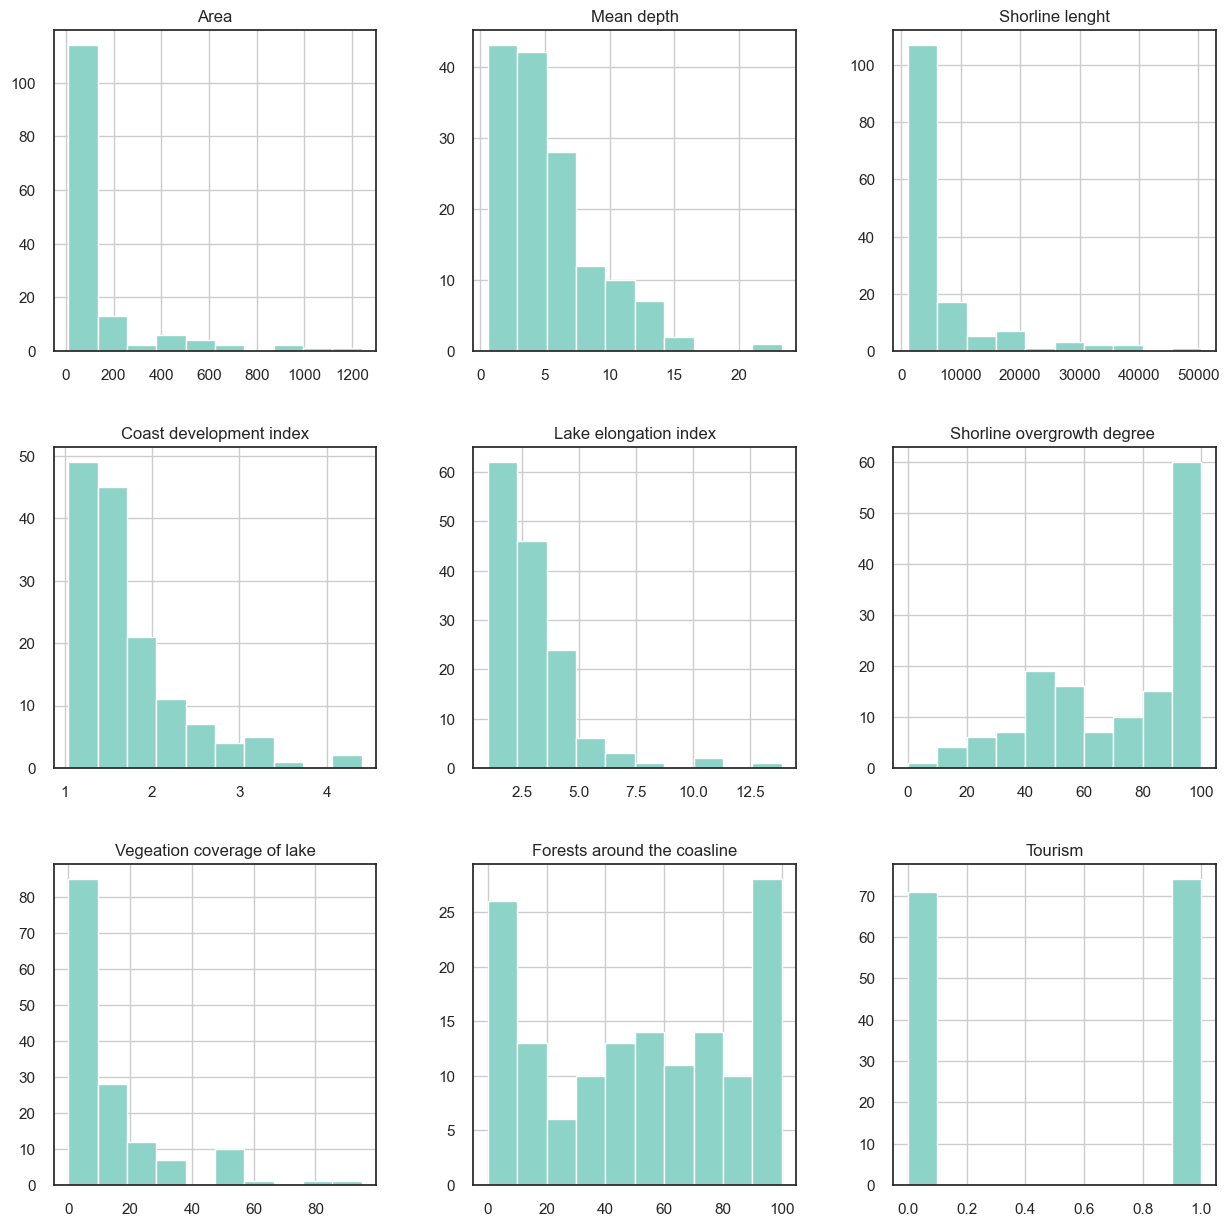

In [9]:
p = df.hist(figsize=(15, 15))

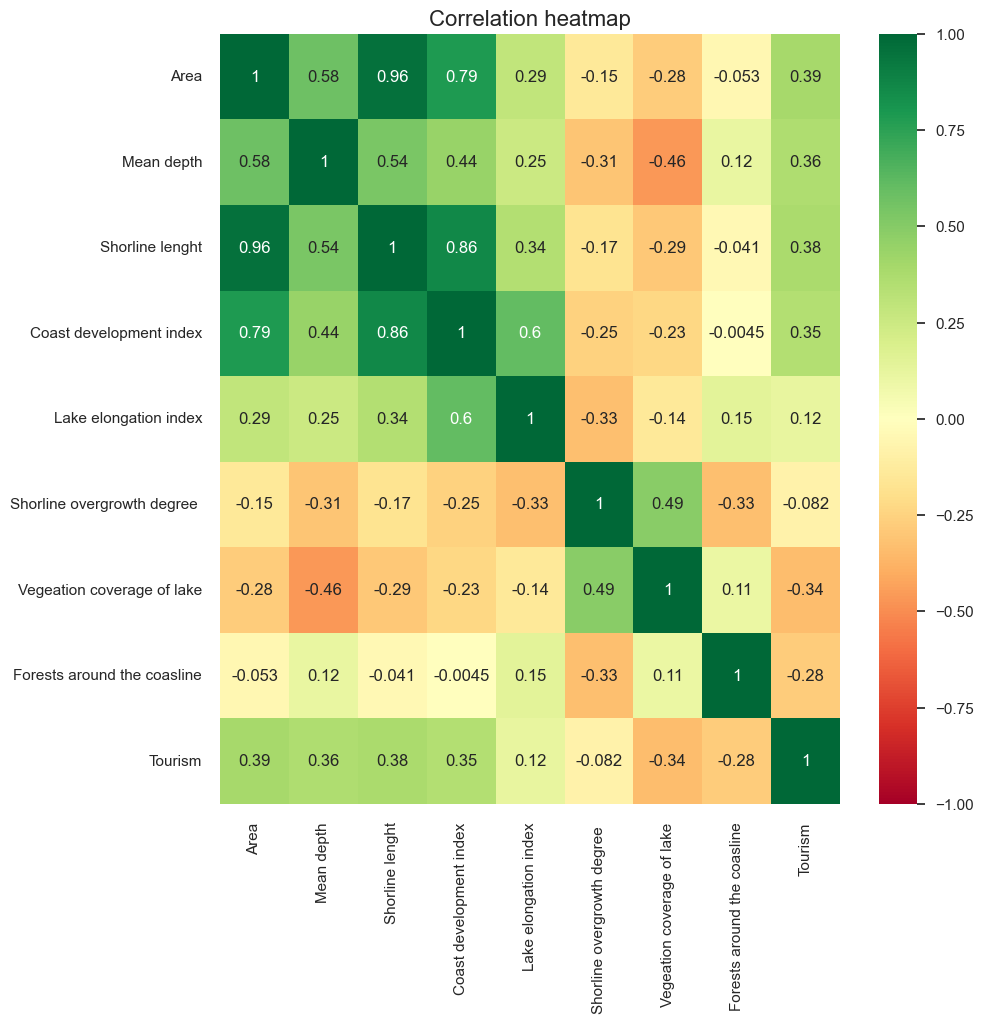

In [10]:
plt.figure(figsize=(10, 10))
corr = df_copy.corr()
corr.index = df_copy.columns
sns.heatmap(corr, annot=True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title('Correlation heatmap', fontsize=16)
plt.show()

<Figure size 800x550 with 0 Axes>

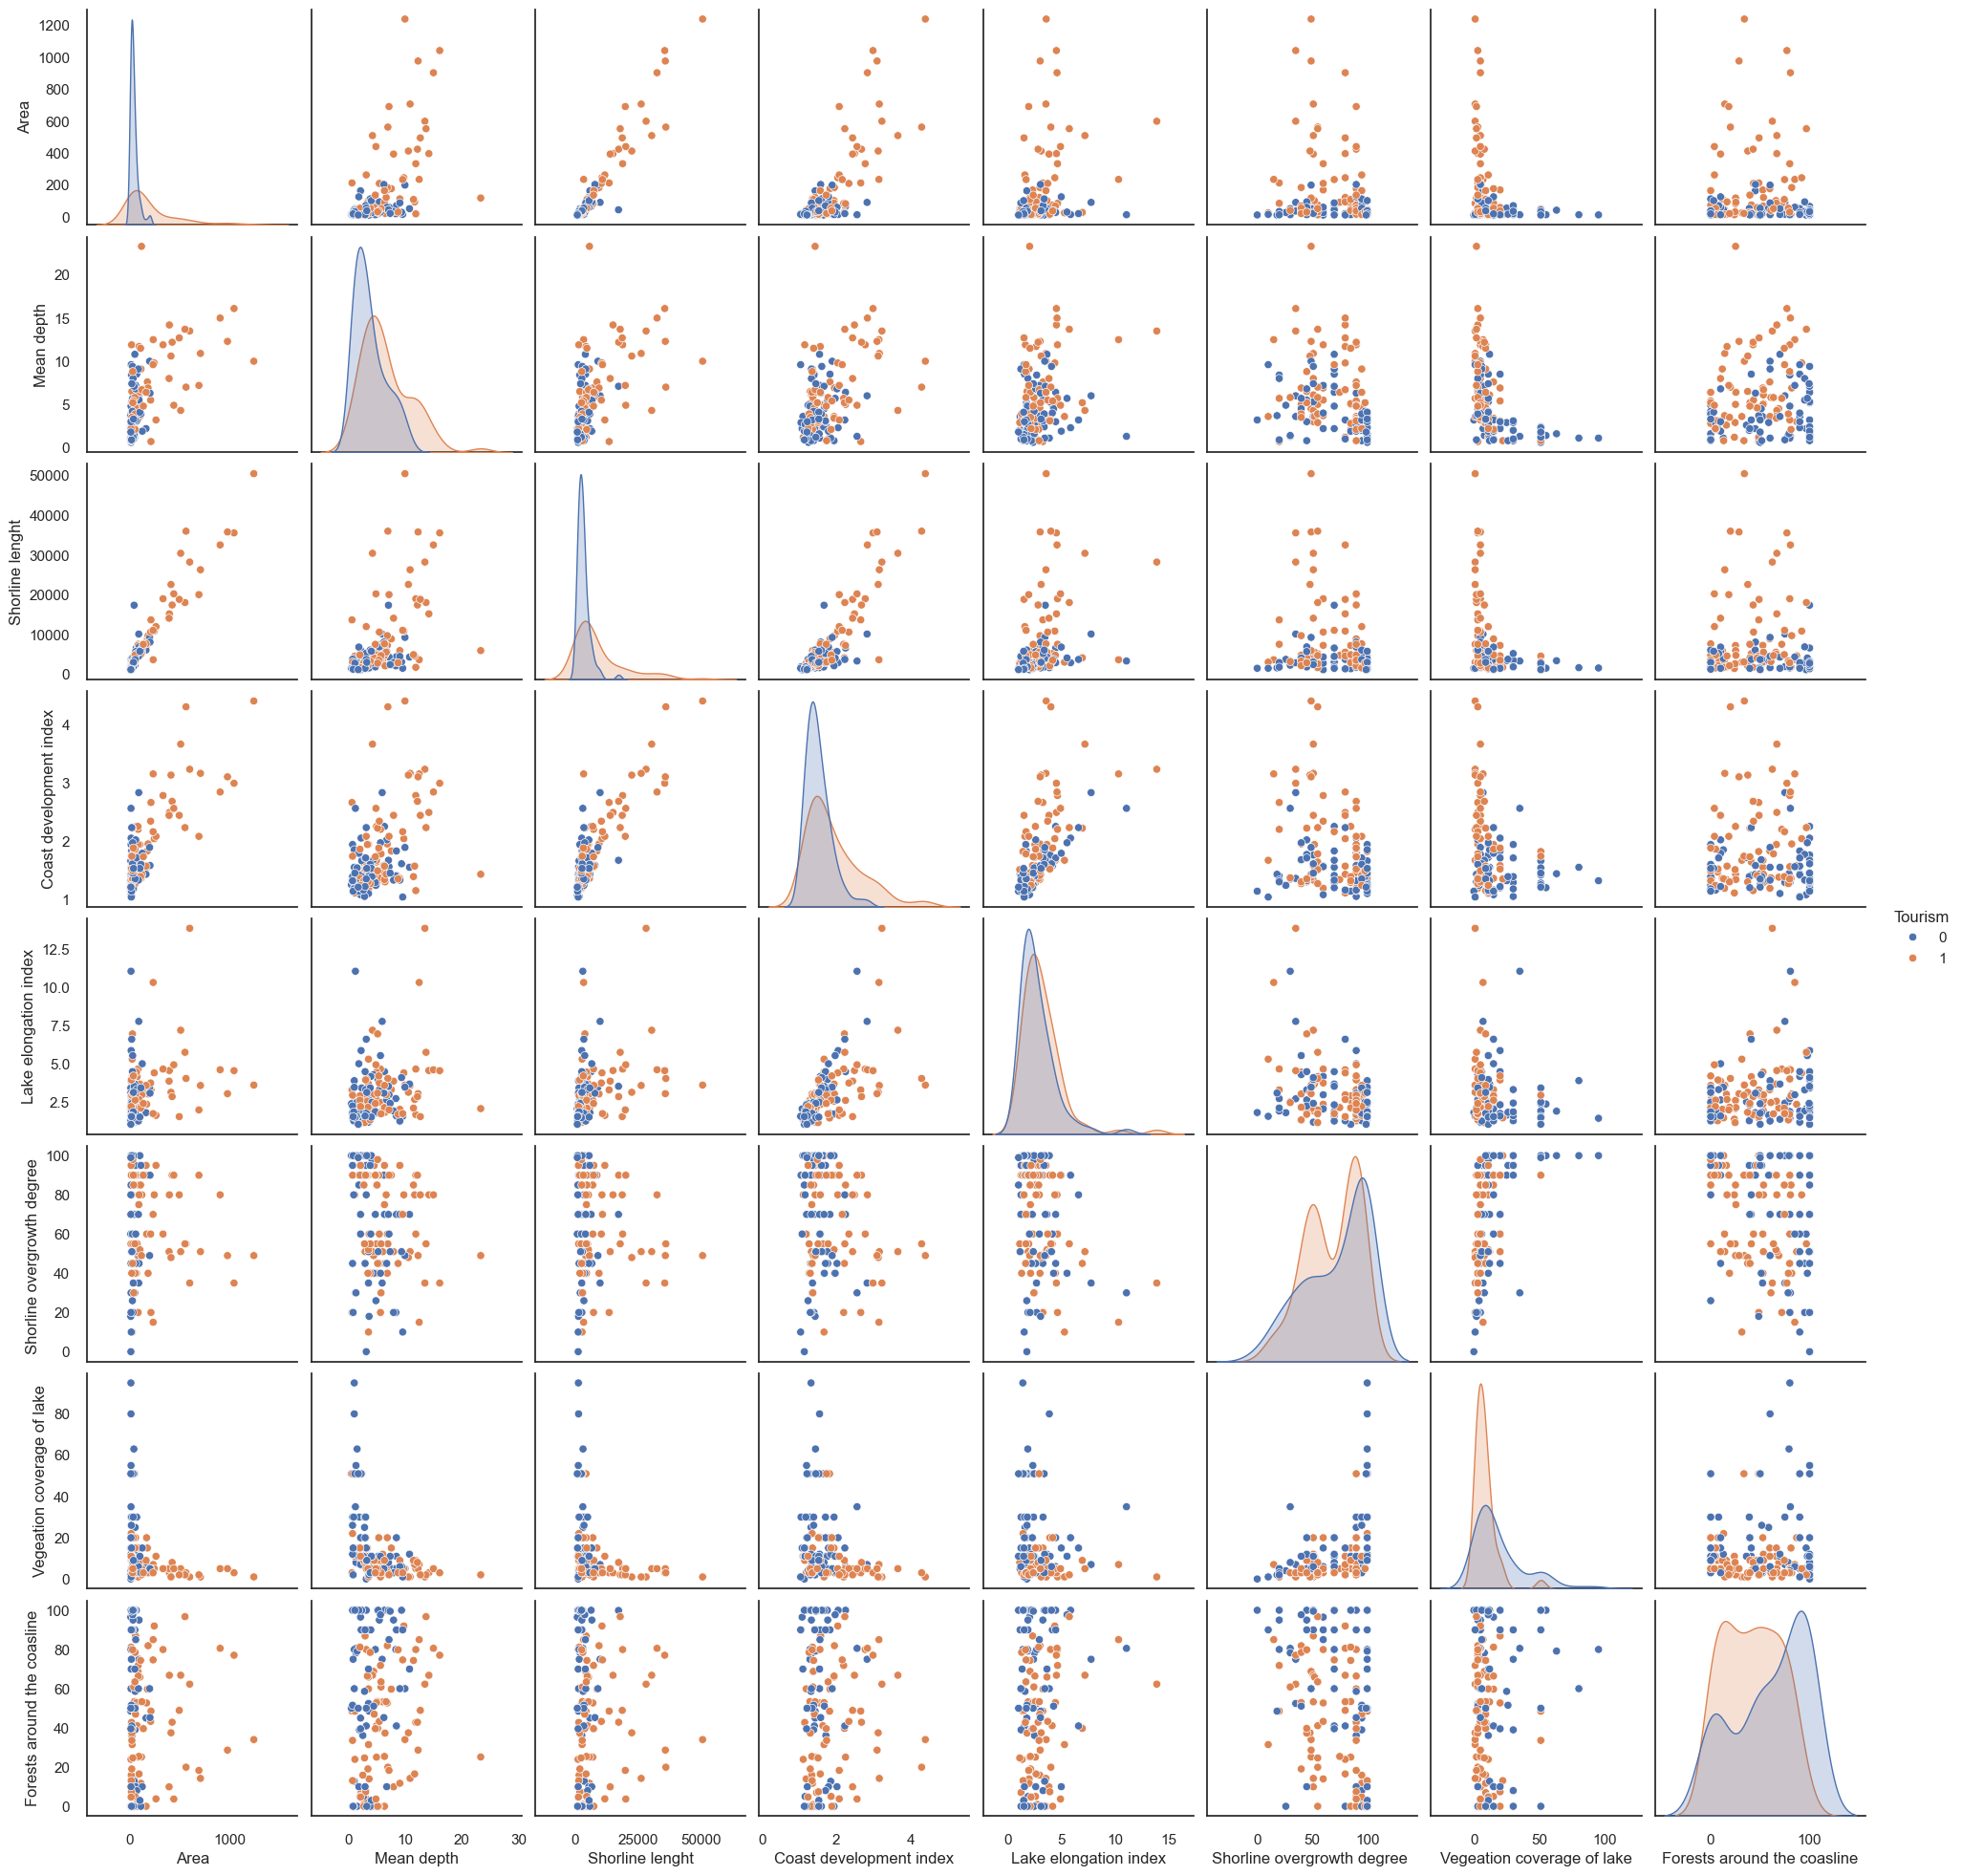

In [11]:
plt.figure()
sns.pairplot(data=df_copy, hue='Tourism', diag_kind='kde', palette='deep')

In [12]:
X = df_copy.iloc[:, :-1]
Y = df_copy.iloc[:, -1]
seed = 7
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)

Shape of X_train: (101, 8)
Shape of X_test: (44, 8)


In [13]:
dum = DummyClassifier(strategy='most_frequent')
dum = dum.fit(X_train, y_train)
score = dum.score(X_test, y_test)
print(f'Dummy Classifier Accuracy: {score * 100.0:.2f}%')

Dummy Classifier Accuracy: 45.45%


Text(0, 0.5, 'Frequency')

<Figure size 700x700 with 0 Axes>

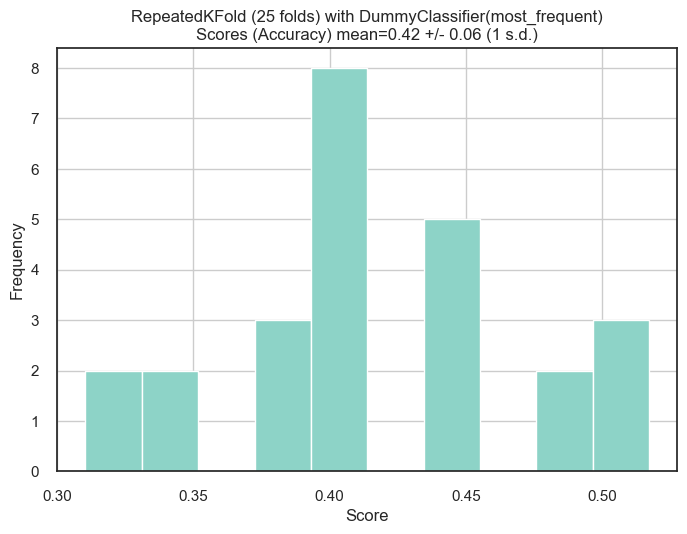

In [14]:
strategy = 'most_frequent'
scores = cross_val_score(dum, X, Y, cv=RepeatedKFold(n_repeats=CV_N_REPEATS), scoring=None)
scores_dummy = scores.copy()
score_line = f'Scores (Accuracy) mean={scores.mean():.2f} +/- {scores.std():.2f} (1 s.d.)'
plt.figure(figsize=(7, 7))
fig, ax = plt.subplots()
pd.Series(scores).hist(ax=ax, bins=BINS)
ax.set_title(f'RepeatedKFold ({len(scores)} folds) with DummyClassifier({strategy})\n' + score_line)
ax.set_xlabel('Score')
ax.set_ylabel('Frequency')

In [15]:
def plot_tree_graph(model, columns, class_names):
    dot_data = export_graphviz(model, feature_names=columns, class_names=class_names)
    graph = graphviz.Source(dot_data)
    return graph


def confusion_mat(y_pred, y_test):
    plt.figure()
    sns.set(font_scale=1.5)
    cm = confusion_matrix(y_pred, y_test)
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

In [16]:
dt = DecisionTreeClassifier(random_state=1, max_depth=3)
dt = dt.fit(X_train, y_train)
dt_scores = cross_val_score(dt, X, Y, cv=RepeatedStratifiedKFold(n_repeats=CV_N_REPEATS))
print(f'Accuracy mean={dt_scores.mean():0.2f} +/- {dt_scores.std():0.2f} (1 s.d.)')

Accuracy mean=0.70 +/- 0.07 (1 s.d.)


In [17]:
bag = BaggingClassifier(n_estimators=100, oob_score=True)
bag = bag.fit(X_train, y_train)
bag_scores = cross_val_score(bag, X, Y, cv=RepeatedStratifiedKFold(n_repeats=CV_N_REPEATS))
print(f'Accuracy mean={dt_scores.mean():0.2f} +/- {dt_scores.std():0.2f} (1 s.d.)')
print(f'Out of bag score: {bag.oob_score_ * 100:0.2f}')

Accuracy mean=0.70 +/- 0.07 (1 s.d.)
Out of bag score: 67.33


Accuracy of Random Forest Classifier: 68.18


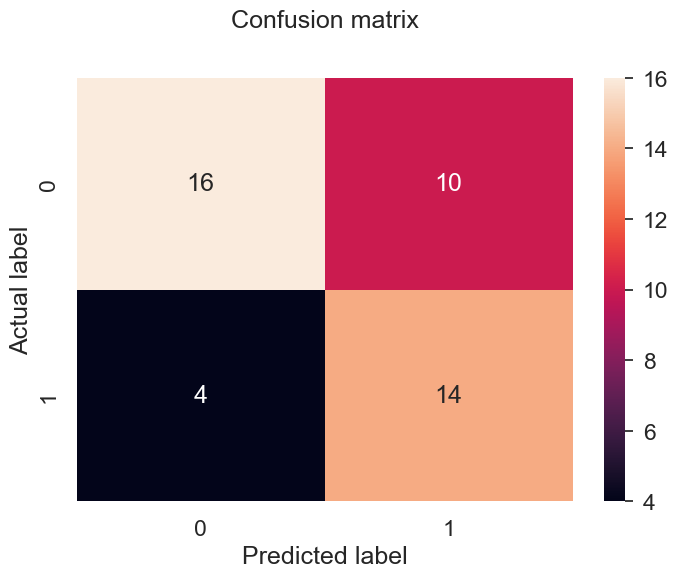

In [18]:
num_estimators = 100
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
rf_score = rf.score(X_test, y_test)
print(f'Accuracy of Random Forest Classifier: {rf_score * 100.0:0.2f}')
y_pred = rf.predict(X_test)
confusion_mat(y_pred, y_test)

In [19]:
feature_names = X_train.columns.values
show_weights(rf, feature_names=feature_names)

Weight,Feature
0.1942 ± 0.2562,Area
0.1757 ± 0.2807,Shorline lenght
0.1453 ± 0.1723,Forests around the coasline
0.1151 ± 0.1727,Coast development index
0.1062 ± 0.1391,Lake elongation index
0.0908 ± 0.1505,Mean depth
0.0886 ± 0.1361,Vegeation coverage of lake
0.0841 ± 0.1549,Shorline overgrowth degree


Scores mean=0.68 +/- 0.10 (1 s.d.)


Text(0, 0.5, 'Frequency')

<Figure size 800x550 with 0 Axes>

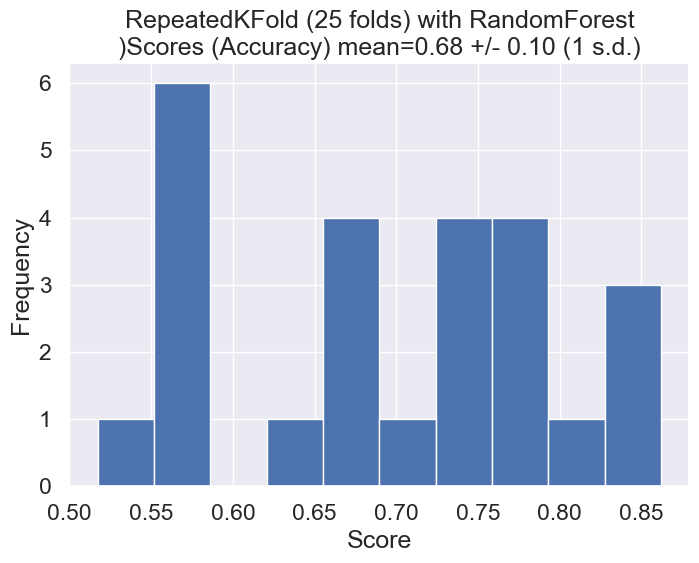

In [20]:
scores = cross_val_score(rf, X, Y, cv=RepeatedStratifiedKFold(n_repeats=CV_N_REPEATS))
scores_est = scores.copy()
print(f'Scores mean={scores.mean():0.2f} +/- {scores.std():0.2f} (1 s.d.)')
score_line = f'Scores (Accuracy) mean={scores.mean():.2f} +/- {scores.std():.2f} (1 s.d.)'
plt.figure()
fig, ax = plt.subplots()
pd.Series(scores).hist(ax=ax, bins=BINS)
ax.set_title(f'RepeatedKFold ({len(scores)} folds) with RandomForest\n)' + score_line)
ax.set_xlabel('Score')
ax.set_ylabel('Frequency')

In [21]:
params = {'n_estimators': 500, 'learning_rate': 0.01, 'max_depth': 5, 'loss': 'log_loss'}
gbm = GradientBoostingClassifier(**params)
gbm.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, n_estimators=500)

Text(0, 0.5, 'Deviance')

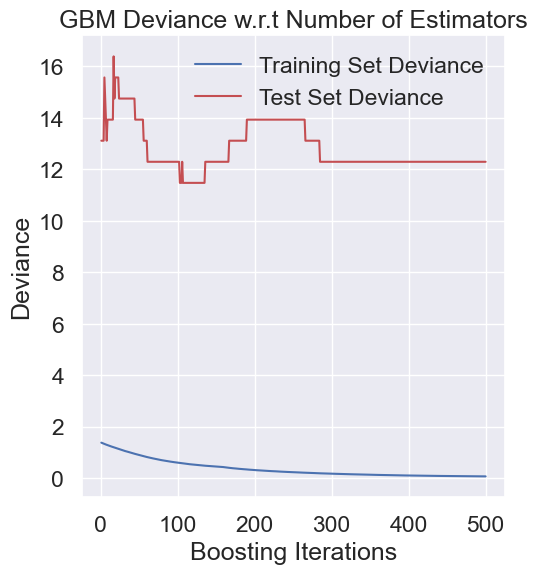

In [22]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(gbm.staged_predict(X_test)):
    test_score[i] = log_loss(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('GBM Deviance w.r.t Number of Estimators')
plt.plot(np.arange(params['n_estimators']) + 1, gbm.train_score_, 'b-', label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-', label='Test Set Deviance')
plt.legend(loc='best')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

Accuracy of GBM Classifier: 61.36


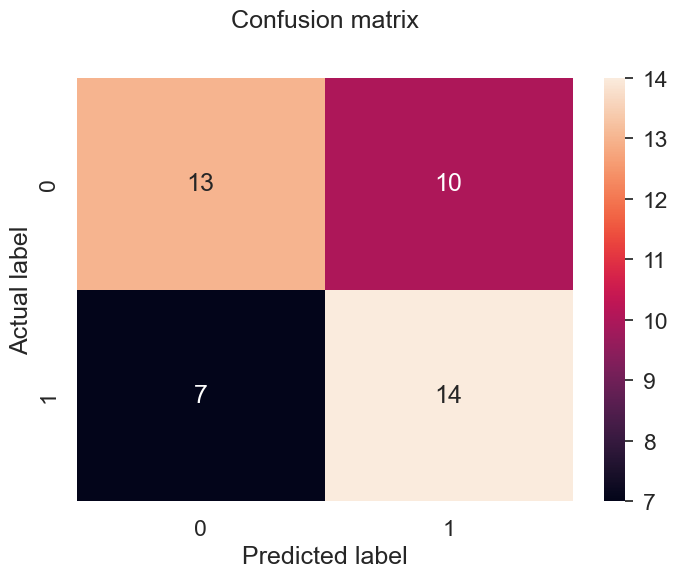

In [23]:
params = {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 4, 'loss': 'log_loss'}
gbm = GradientBoostingClassifier(**params)
gbm.fit(X_train, y_train)

y_pred = gbm.predict(X_test)
gbm_score = accuracy_score(y_test, y_pred)
print(f'Accuracy of GBM Classifier: {gbm_score * 100.0:0.2f}')
confusion_mat(y_pred, y_test)

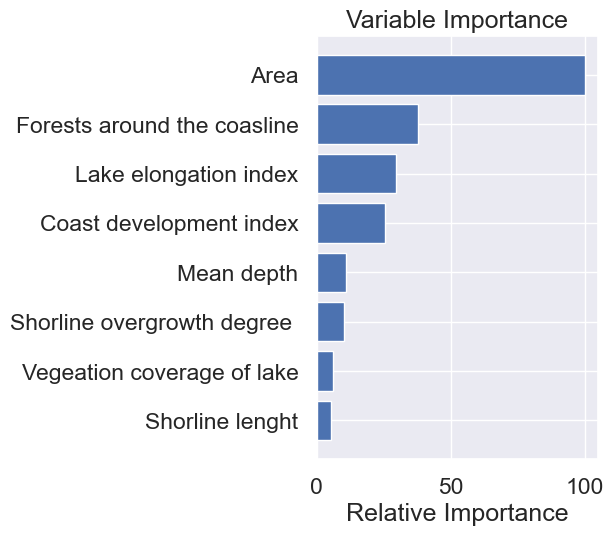

In [24]:
feature_importance = gbm.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [25]:
param = {'max_depth': 10, 'eta': 0.8, 'subsample': 1, 'objective': 'binary:logistic', 'n_estimators': 1000, 'learning_rate': 0.001}
xgb = XGBClassifier(**param)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.8, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

Accuracy of XGBoost Classifier: 59.09


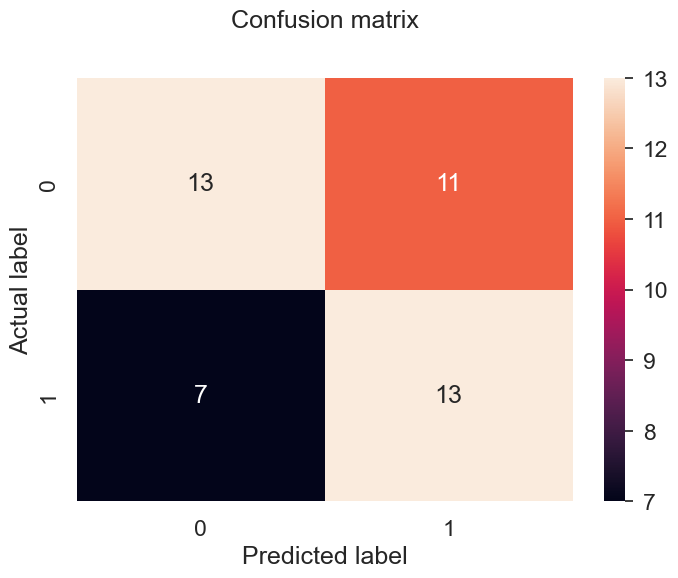

In [26]:
y_pred = xgb.predict(X_test)
xgb_score = accuracy_score(y_test, y_pred)
print(f'Accuracy of XGBoost Classifier: {xgb_score * 100.0:0.2f}')
confusion_mat(y_pred, y_test)

<Figure size 800x550 with 0 Axes>

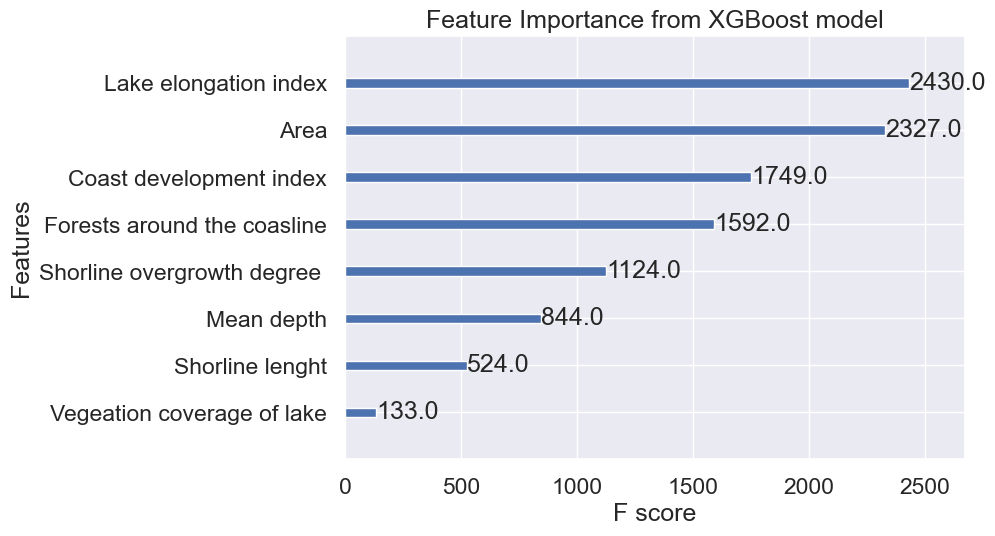

In [27]:
plt.figure()
plot_importance(xgb, title='Feature Importance from XGBoost model')
plt.show()

In [28]:
model = XGBClassifier(n_estimators=1000, max_depth=10, learning_rate=0.001)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [29]:
y_pred = model.predict(X_test)
model_score = accuracy_score(y_test, y_pred)
print(f'Accuracy of XGB Classifier: {model_score * 100.0:0.2f}')
confusion_matrix(y_pred, y_test)

Accuracy of XGB Classifier: 59.09


array([[13, 11],
       [ 7, 13]])

In [30]:
shap.initjs()

In [31]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [32]:
i = 0
shap.force_plot(explainer.expected_value, shap_values[i], features=X.iloc[i], feature_names=X.columns)

In [33]:
i = 109
shap.force_plot(explainer.expected_value, shap_values[i], features=X.iloc[i], feature_names=X.columns)

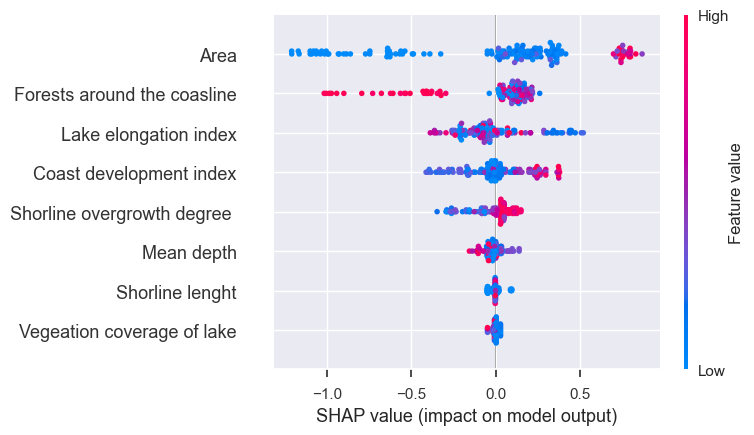

In [34]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns, show=False)
plt.savefig('plot.png', dpi=300, bbox_inches='tight')
plt.show()

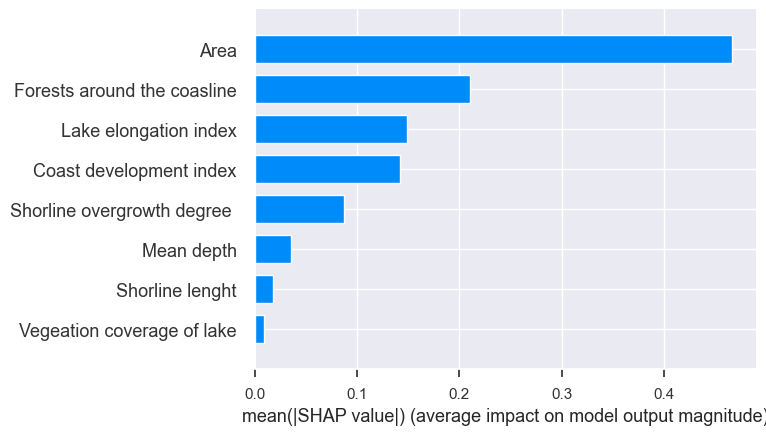

In [35]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns, show=False, plot_type='bar')
plt.savefig('plot_bar.png', dpi=300, bbox_inches='tight')
plt.show()

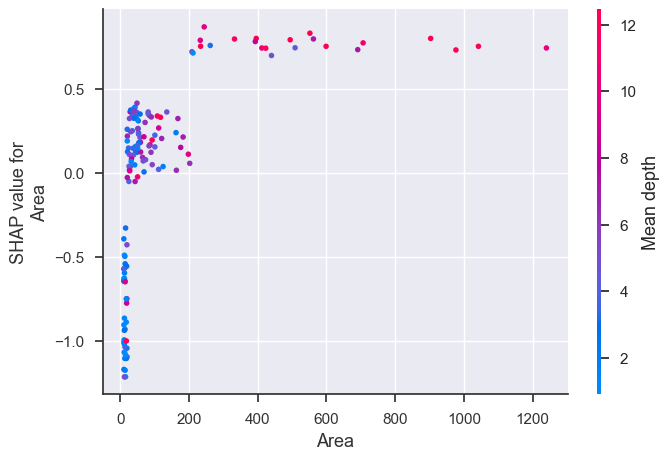

In [36]:
shap.dependence_plot('Area', shap_values, features=X, interaction_index='Mean depth')

In [37]:
shap.force_plot(explainer.expected_value, shap_values[:121, :], show=False, features=X.iloc[:121, :])